## Advanced Lane Lines Detection
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

Apply a distortion correction to raw images.

Apply a perspective transform to rectify image ("birds-eye view").

Use color transforms, gradients, etc., to create a thresholded binary image.

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob

%matplotlib inline

In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [3]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob(img)
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints


def cal_undistort(image,nx,ny):
    objpoints,imgpoints=corners_unwarp(image,nx,ny)
    image = mpimg.imread(image)

    img_size = (image.shape[1], image.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)

    return undist, mtx, dist

# Camera Calibration
Calculate the correct camera matrix and distortion coefficients using the calibration chessboard images

In [38]:
def CameraCalibration(image, visualise=False):
    #calibration for camera
    nx=9
    ny=5
    undist, mtx, dist= cal_undistort(image,nx,ny)
    if visualise:
        image = mpimg.imread(image)

        f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
        ax1.imshow(image, cmap='gray')
        ax1.title.set_text('Original image')

        ax2.imshow(undist, cmap='gray')
        ax2.title.set_text('undistion')
        #plt.imsave('Output_Process_Image',f)
        plt.savefig('Output_Process_Image/calibration_output.jpg')
    return mtx, dist

image_cal='camera_cal/calibration1.jpg'
mtx, dist = CameraCalibration(image_cal, visualise=False)



In [5]:
#reading in an image
#image = mpimg.imread('frame.jpg')
image = mpimg.imread('./test_images/test1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


# Distortion correction

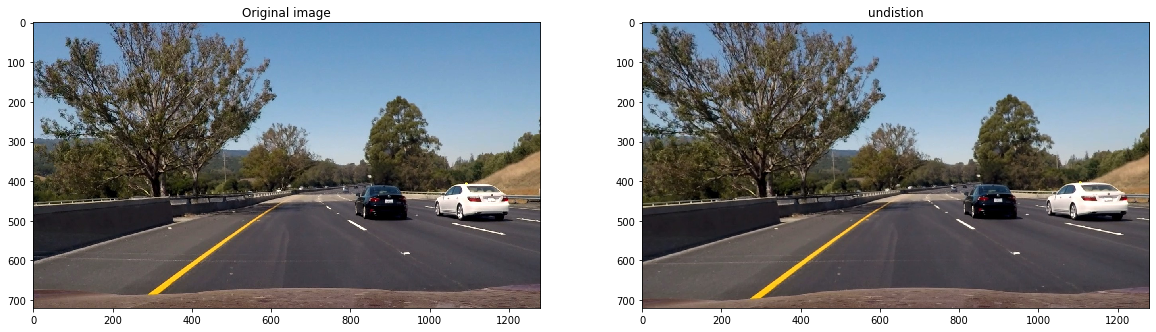

In [39]:
img_undist = cv2.undistort(image, mtx, dist, None, mtx)

f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(image, cmap='gray')
ax1.title.set_text('Original image')

ax2.imshow(img_undist, cmap='gray')
ax2.title.set_text('undistion')
plt.savefig('Output_Process_Image/undistion_output.jpg')


# Apply the parameters to the undistorted image

In [40]:
position = [[580,450],[240,670],[1055,670],[710,450]]
def thresh(img, thresh_min, thresh_max):
    ret = np.zeros_like(img)
    ret[(img >= thresh_min) & (img <= thresh_max)] = 1
    return ret

def CLAHEinput(image):
     # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(image)
    return cl1

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count

    else:
        ignore_mask_color = 1

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def addcolor(image,r,g,b):
    image_rgb = np.float32(image)
    rgb = cv2.cvtColor(image_rgb, cv2.COLOR_GRAY2RGB) # RGB for matplotlib, BGR for imshow() !
    rgb *= np.array((r,g,b),np.uint8) # set r and b to 0, leaves red
    return rgb 

def color_thresh(image, visualise=False):
    b = np.zeros((image.shape[0],image.shape[1]))
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    H = hsv[:,:,0]
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    V=CLAHEinput(V)
    if np.mean(S)<70:
        S=CLAHEinput(S)
    if np.mean(R)<80:
        R=CLAHEinput(R)  
    t_yellow_H = thresh(H,10,30)
    t_yellow_S = thresh(S,70,255)
    t_yellow_V = thresh(V,150,255)
    t_white_R = thresh(R,225,255)
    t_white_V = thresh(V,240,255)
    b[(t_yellow_H==1) & (t_yellow_S==1) & (t_yellow_V==1)] = 1
    b[(t_white_R==1)|(t_white_V==1)] = 1

    
    
    b_rgb=addcolor(b,r=0,g=1,b=0)
    pos_margin=[[-100,0],[-100,0],[100,0],[100,0]]
    position_mask = [list(map(lambda x,y: x+y, position[i],pos_margin[i]))for i in range(0,4)]#add margin on the position for the mask
    vertices = np.array([position_mask], dtype=np.int32)
    b_masked=region_of_interest(b, vertices)
    masked_rgb=addcolor(b_masked,r=0,g=0,b=1)

    img_stack = cv2.addWeighted(b_rgb, 1, masked_rgb, 1, 0)
    if visualise:
        f,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9),(ax10,ax11,ax12),(ax13,ax14,ax15))=plt.subplots(5,3,figsize=(20,15))
        ax1.imshow(R, cmap='gray')
        ax1.title.set_text('R')
        ax2.imshow(G, cmap='gray')
        ax2.title.set_text('G')
        ax3.imshow(B, cmap='gray')
        ax3.title.set_text('B')
        ax4.imshow(H, cmap='gray')
        ax4.title.set_text('H')
        ax5.imshow(S, cmap='gray')
        ax5.title.set_text('s')
        ax6.imshow(V, cmap='gray')
        ax6.title.set_text('v')
        ax7.imshow(t_yellow_H, cmap='gray')
        ax7.title.set_text('t_yellow_H')
        ax8.imshow(t_yellow_S, cmap='gray')
        ax8.title.set_text('t_yellow_S')
        ax9.imshow(t_yellow_V, cmap='gray')
        ax9.title.set_text('t_yellow_V')
        ax10.imshow(t_white_R, cmap='gray')
        ax10.title.set_text('t_white_R')
        ax11.imshow(t_white_V, cmap='gray')
        ax11.title.set_text('t_white_V')
        ax12.imshow(b, cmap='gray')
        ax12.title.set_text('b')
        
        ax13.imshow(b_rgb, cmap='gray')
        ax13.title.set_text('b_rgb')
        ax14.imshow(masked_rgb, cmap='gray')
        ax14.title.set_text('masked_rgb')
        ax15.imshow(img_stack, cmap='gray')
        ax15.title.set_text('img_stack')
        plt.savefig('Output_Process_Image/color_thresh.jpg')

    return b,img_stack

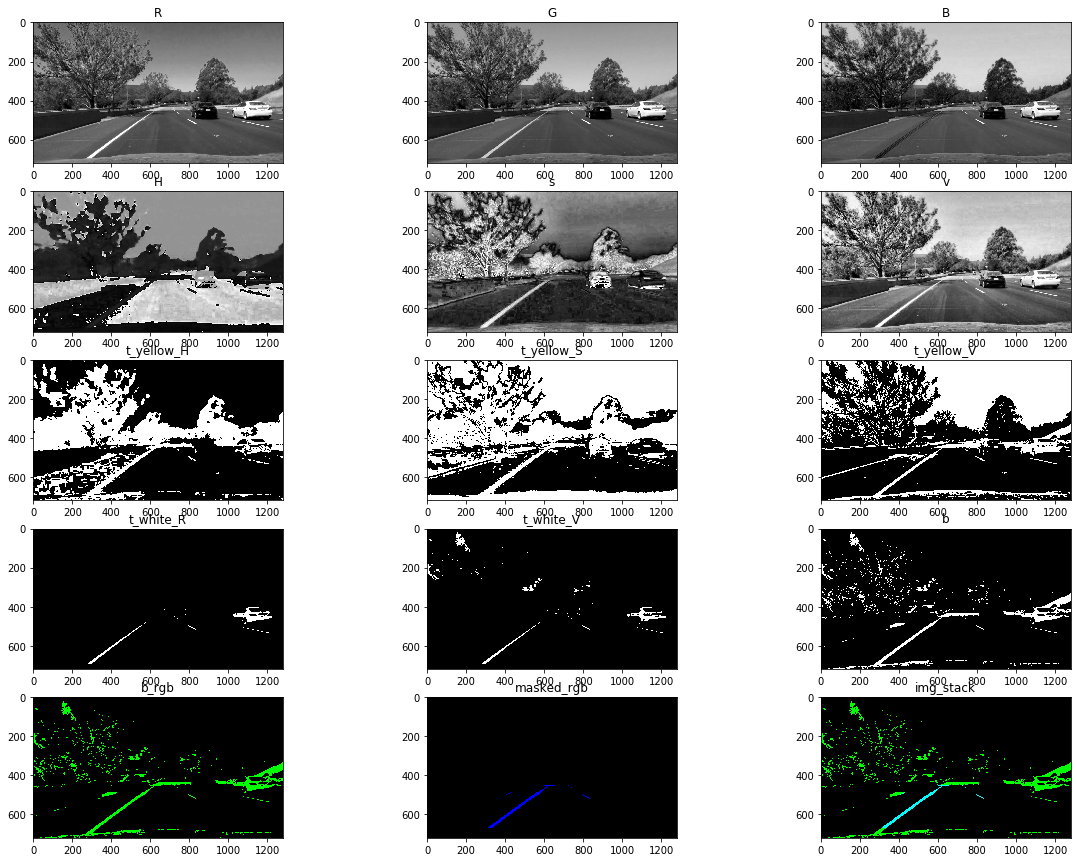

In [41]:
binary,img_stack= color_thresh(img_undist, visualise=True)


# Bird view

In [42]:
def img_warp(img, visualise=False):
    img_size=(img.shape[1],img.shape[0])
    #find the position of the straight line
    src=np.float32(
    position)
    dst=np.float32(
    [[200,0],
    [200,720],
    [1080,720],
    [1080,0]])
    #transfer the image into bird view
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    if visualise:
        f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
        ax1.imshow(img, cmap='gray')
        ax1.title.set_text('binary')
        ax1.plot(position[0][0],position[0][1],'.')
        ax1.plot(position[1][0],position[1][1],'.')
        ax1.plot(position[2][0],position[2][1],'.')
        ax1.plot(position[3][0],position[3][1],'.')
        ax2.imshow(warped, cmap='gray')
        ax2.title.set_text('Warped Binary')
        ax2.plot(200,0,'.')
        ax2.plot(200,720,'.')
        ax2.plot(1080,720,'.')
        ax2.plot(1080,0,'.')
        plt.savefig('Output_Process_Image/warped.jpg')

    return warped,M,Minv

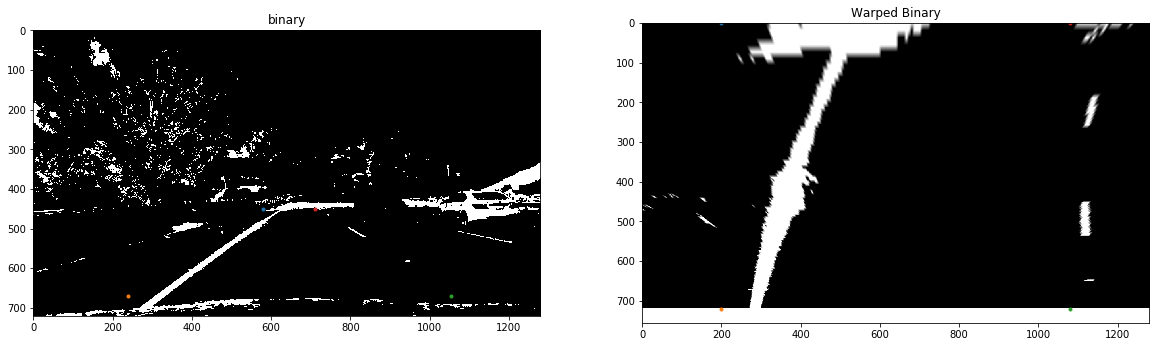

In [43]:
binary_warped,M,Minv=img_warp(binary, visualise=True)

In [11]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_allx = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = []
        #distance in meters of vehicle center from the line
        self.line_base_pos = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.frameNr=0
        self.margin=[]

    def smooth(self,LR_fit):
        #x values of the last n fits of the line
        self.recent_allx.append(list(LR_fit)) 

        FrameNr=3
        MarginFrameNr=FrameNr
        if len(self.recent_allx)>=FrameNr:
            self.recent_allx=self.recent_allx[FrameNr*(-1):]

            Frame_Mean = np.mean(self.recent_allx[FrameNr*(-1):-2],axis=0)
            Diff=np.subtract(self.recent_allx[-1],self.recent_allx[-2])

            self.margin.append(list(Diff)) 

            if len(self.margin)>=MarginFrameNr:
                self.margin=self.margin[MarginFrameNr*(-1):]
                self.margin=self.margin[MarginFrameNr*(-1):]
                Margin_Mean = np.abs(np.mean(self.margin,axis=0))
                for i in range(3):
                    if abs(Diff[i])>= Margin_Mean[i]*1000: 
                        LR_fit[i]=Frame_Mean[i]

Left_Lane=Line()
Right_Lane=Line()
Lane=Line()

# Find lanes

In [12]:
def find_lane_pixels(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((image, image, image))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 11
    # Set the width of the windows +/- margin
    margin = 160
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =leftx_current-margin
        win_xleft_high =leftx_current+margin
        win_xright_low =rightx_current-margin
        win_xright_high =rightx_current+margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left=((nonzeroy>=win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high))
        good_right=((nonzeroy>=win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high))
        good_left_inds = good_left.nonzero()[0]
        good_right_inds =good_right.nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


In [44]:
def fit_polynomial(image, visualise=False):

    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(image)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2) 
   
    # If the difference between two frames over a contain range, left_fit/ right_fit will be modified with the mean value.
    Left_Lane.smooth(left_fit)
    Right_Lane.smooth(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, binary_warped.shape[0] )
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    try:
        left_fitx = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2]
        right_fitx = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, nonzeroy]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, nonzeroy])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
     # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    cv2.polylines(out_img, np.int_([pts_left]),isClosed=False,color=(255,255,0), thickness=10)
    cv2.polylines(out_img, np.int_([pts_right]),isClosed=False,color=(0,255,0), thickness=10)
    if visualise:
        f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
        ax1.imshow(image, cmap='gray')
        ax2.imshow(out_img, cmap='gray')
        plt.savefig('Output_Process_Image/fit_polynomial.jpg')


    return out_img,newwarp,left_fit,right_fit,left_fitx,right_fitx

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


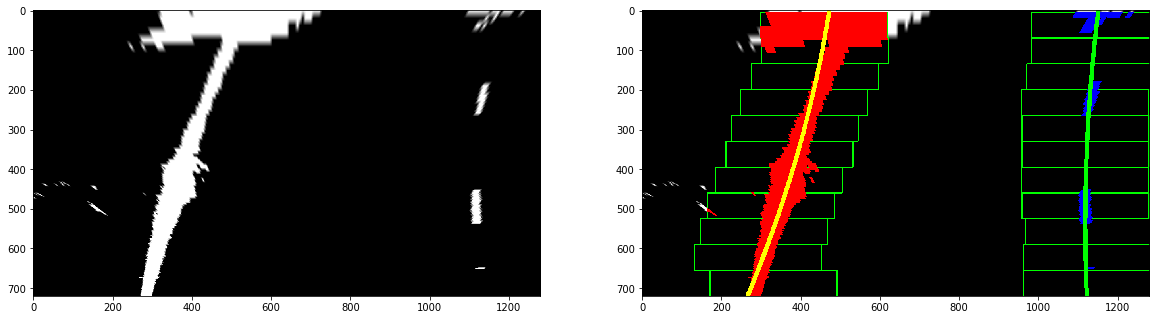

In [45]:
out_img,newwarp,left_fit,right_fit,left_fitx,right_fitx=fit_polynomial(binary_warped, visualise=True)
    # Combine the result with the original image

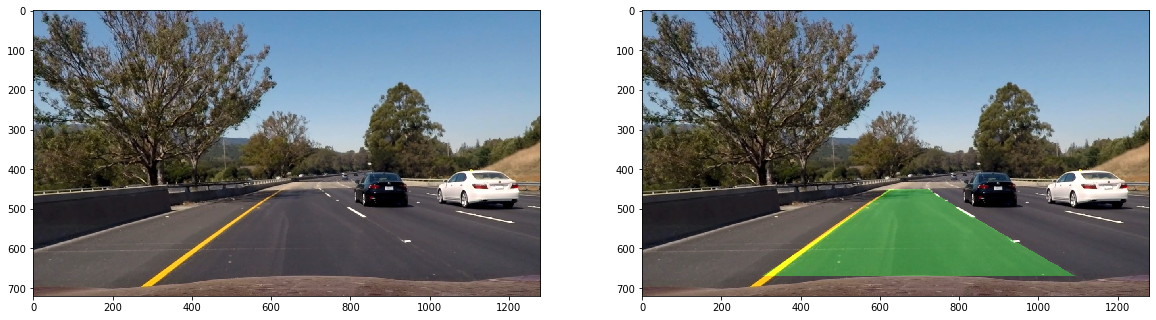

In [49]:
ImageResult = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_undist, cmap='gray')
ax2.imshow(ImageResult, cmap='gray')
plt.savefig('Output_Process_Image/addWeighted.jpg')


# Add infomation

In [16]:
def measure_curvature_offset_real(left_fit, right_fit,left_fitx,right_fitx,image):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    ## Implement the calculation of the left line here
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, 'm', right_curverad, 'm')
    
    #Calulate offset
    # Image mid horizontal position 
    mid_imgx = image.shape[1]/2 
    # Car position with respect to the lane
    car_pos = (left_fitx[-1] + right_fitx[-1])/2

    # Horizontal car offset 
    offsetx = (mid_imgx - car_pos) * xm_per_pix
    
    Left_Lane.detected = True        
    Right_Lane.detected = True   

    Left_Lane.radius_of_curvature.append(np.array(left_curverad)) 
    Right_Lane.radius_of_curvature.append(np.array(right_curverad))
    Lane.line_base_pos.append(np.array(car_pos))

    return left_curverad, right_curverad, offsetx

    
def addInfo(img,left_curverad,right_curverad,offsetx):
    out_img = img.copy()
    Left_Lane.frameNr=Left_Lane.frameNr+1
    cv2.putText(out_img, 'Left lane line curvature: {:.2f} m'.format(left_curverad), 
                (60, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    cv2.putText(out_img, 'Right lane line curvature: {:.2f} m'.format(right_curverad), 
                (60, 110), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    # Display car offset
    cv2.putText(out_img, 'Horizontal car offset: {:.2f} m'.format(offsetx), 
                (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    #Display the frame number
    cv2.putText(out_img, 'Frame:{:.1f} m'.format(Left_Lane.frameNr), 
                (60, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 5)
    
    return out_img

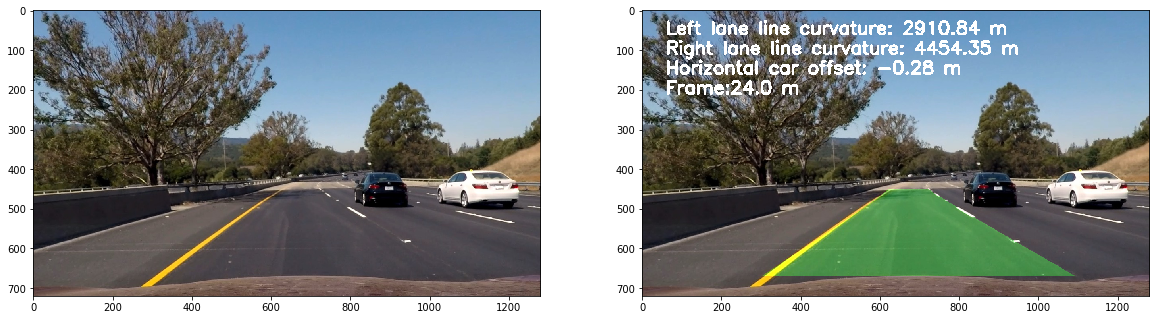

In [47]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offsetx = measure_curvature_offset_real(left_fit, right_fit,left_fitx,right_fitx,image)
Image_info = addInfo(ImageResult,left_curverad,right_curverad,offsetx)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_undist, cmap='gray')
ax2.imshow(Image_info, cmap='gray')
plt.savefig('Output_Process_Image/addInfo.jpg')


In [50]:
def image_process(image):
    visualise=True
    image_cal='camera_cal/calibration1.jpg'
    mtx, dist = CameraCalibration(image_cal, visualise=False)
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    position = [[580,450],[240,670],[1055,670],[710,450]]

    
    binary,img_stack = color_thresh(img_undist, visualise=False)
    binary_warped,M,Minv=img_warp(binary, visualise=False)

    out_img,newwarp,left_fit,right_fit,left_fitx,right_fitx=fit_polynomial(binary_warped, visualise=False)
    Image_Result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)

    left_curverad, right_curverad, offsetx = measure_curvature_offset_real(left_fit, right_fit,left_fitx,right_fitx,image)
    Image_info=addInfo(Image_Result,left_curverad,right_curverad,offsetx)
    #Image_info=cv2.cvtColor(Image_info, cv2.COLOR_BGR2RGB)
    
    output = Image_info
    output1 = cv2.resize(img_stack,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(out_img,(640, 360), interpolation = cv2.INTER_AREA)
    # Create an array big enough to hold both images next to each other.
    Image_output_vis = np.zeros((720, 1280+640, 3))
    # Copy both images into the composed image.
    Image_output_vis[:720, :1280,:] = output
    Image_output_vis[:360, 1280:1920,:] = output1*255
    Image_output_vis[360:720, 1280:1920,:] = output2

    if visualise:
        f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(20,10))
        ax1.imshow(img_undist, cmap='gray')
        ax1.title.set_text('Undistort Image')

        ax2.imshow(Image_info, cmap='gray')
        ax2.title.set_text('Image processed with Info.')
        
        ax3.imshow(img_stack, cmap='gray')
        ax3.title.set_text('Color Thresh')
        
        ax4.imshow(out_img, cmap='gray')
        ax4.title.set_text('Bird view of Lanes')


        plt.figure(figsize=(10,10))
        plt.imshow(Image_output_vis,cmap='gray')
        plt.title('Output Visualised')
        #plt.savefig('Output_Process_Image/Image_output_vis.jpg')
    return Image_output_vis 

    

# Pipeline (test images)

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


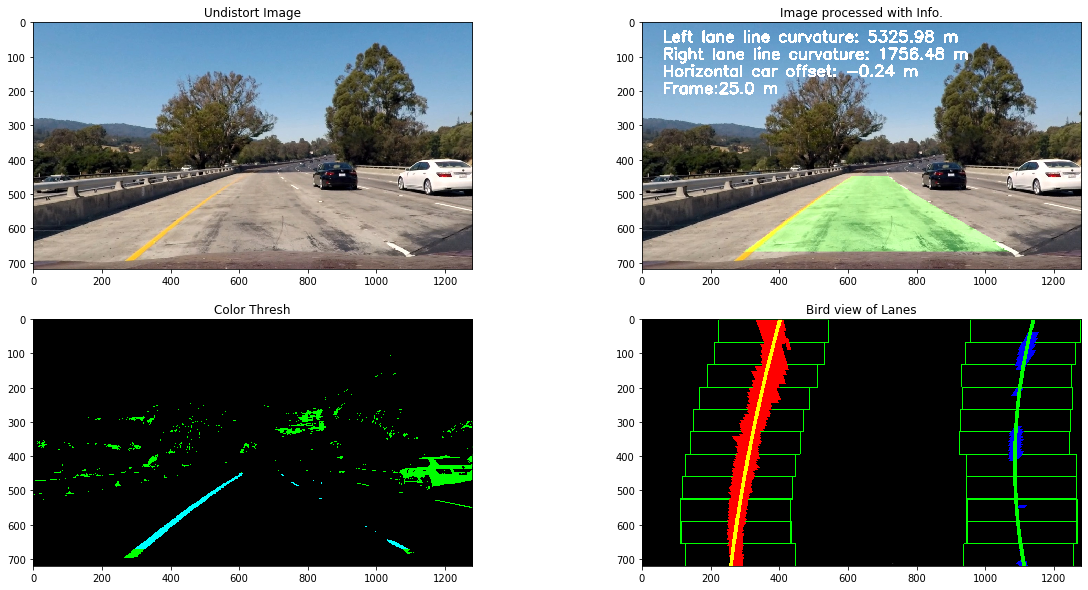

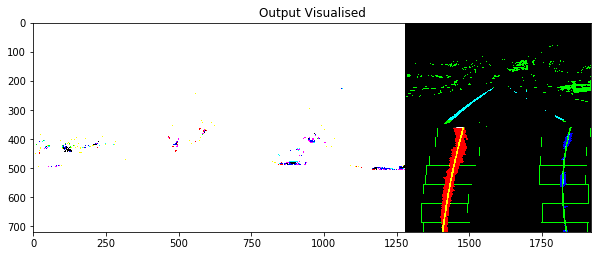

In [51]:
#reading in an image
image = mpimg.imread('test_images/test1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
Image_output_vis=image_process(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Floating point image RGB values must be in the 0..1 range.

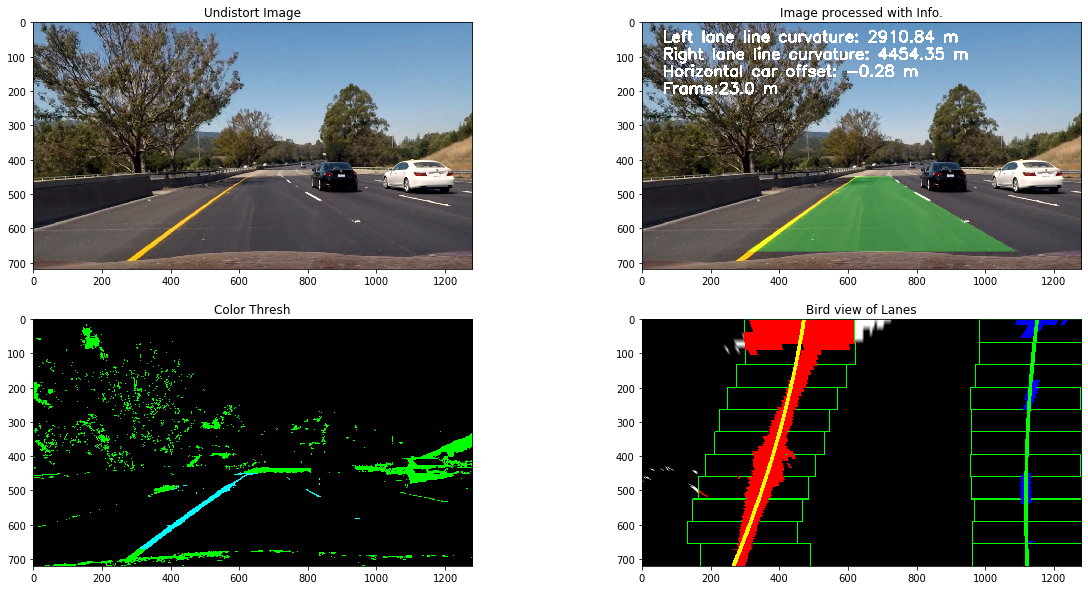

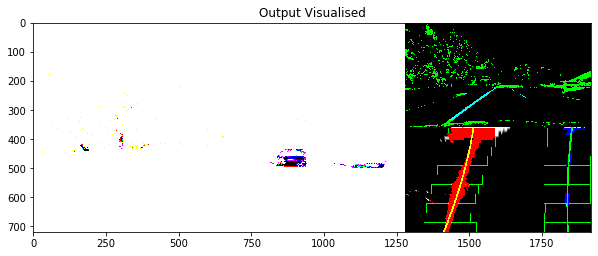

In [27]:
import os
images=os.listdir("test_images/")

for imageName in images:
    if imageName.endswith("jpg"):
        image = mpimg.imread('test_images/{}'.format(imageName))
        Image_output_vis=image_process(image)
        #print('This image is:', type(image), 'with dimensions:', image.shape)
        #cv2.imwrite('test_images_output/{}_result.jpg'.format(imageName[:-4]),Image_output_vis)

# Pipeline (test video)

In [ ]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

clip1 = VideoFileClip(input_video)#.subclip(40,42)

Left_Lane=Line()
Right_Lane=Line()
Lane=Line()
white_clip = clip1.fl_image(image_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)


In [ ]:
output_video = './project_video_solution.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))